<span style="font-family:Georgia; font-size:25pt">
Regression analysis
</span>

1. Exploring and visualizing
2. Different approaches
3. Training models robust to outliers
4. Evaluation and diagnosis
5. Nonlinear data

In [78]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set('poster')
sns.set_style('whitegrid')

plt.style.use = 'default'
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

from IPython.display import Image

# Simple linear regression
> In contrast to common belief, training a linear regression model does not require that the explanatory or target variables are normally distributed.

Housing dataset

In [4]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',header=None,sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Scatter plot

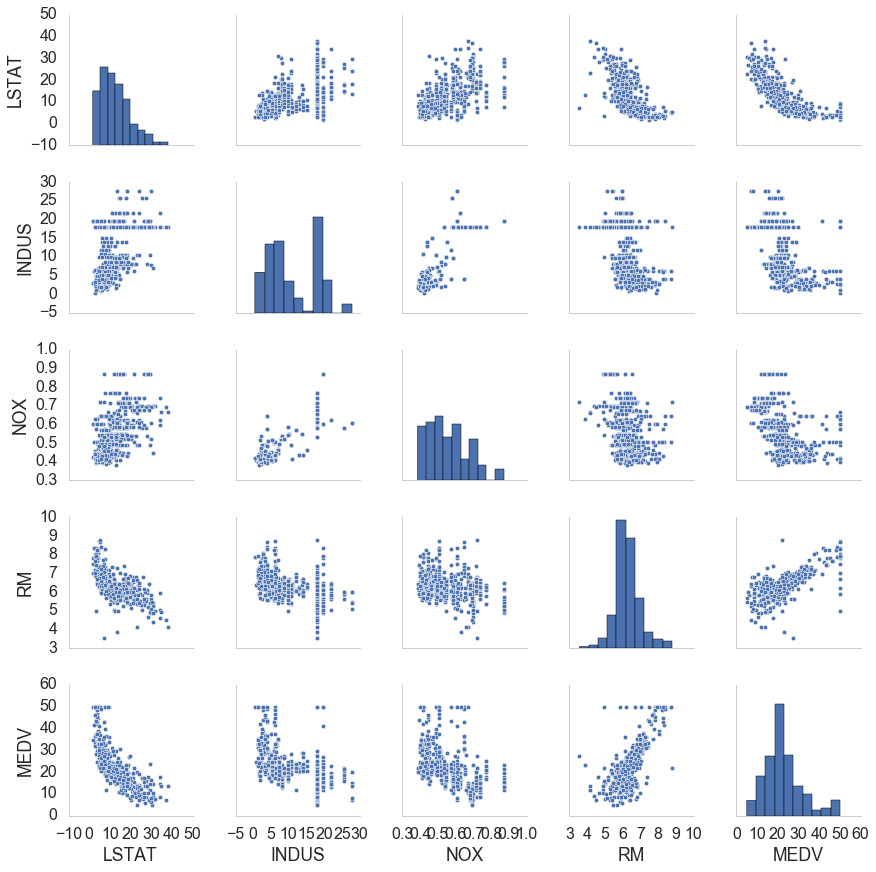

In [12]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5)
plt.show()

## Correlation matrix
- Rescaled version of the covariance matrix.
- Contains **Pearson product-moment correlation coefficients (aka Pearson's r)** [-1, 1]

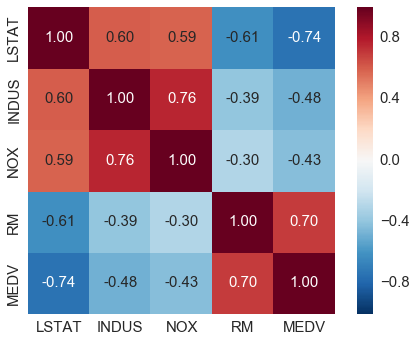

In [23]:
import numpy as np
cm = np.corrcoef(df[cols].values.T) 
# without transpose, you will get n_sample x n_sample matrix
#  (`x` represents a variable, and each column a single observation of all those variables.)

sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.show()

# Ordinary least squares (OLS)
Estimate the parameters of the regression line that **minimizes the SSE** to the sample points

## Solving regression with gradient descent
**Cost function**: same as Adaline (1/2 x sum (y_pred - y_true)^2); thus, it's essentially Adaline without the unit step function

In [53]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

Note that below, X has <span class="mark">two brackets</span>.

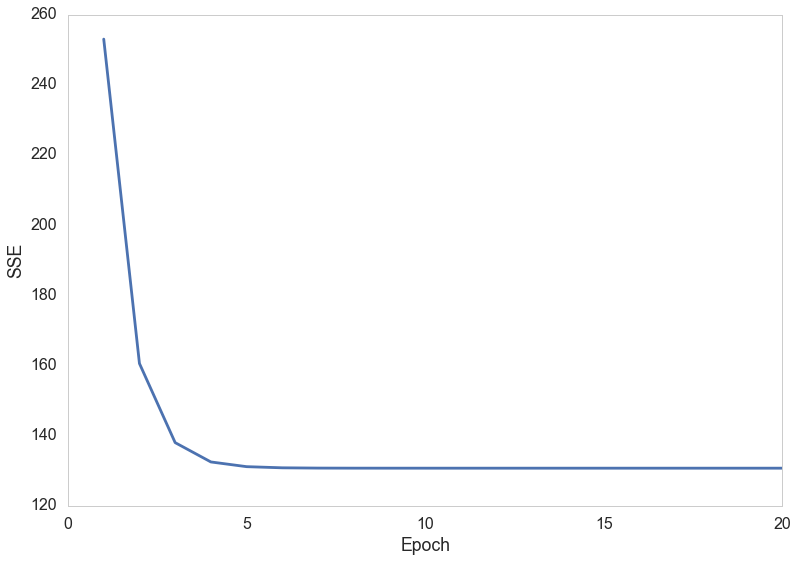

In [59]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD()
lr.fit(X_std, y_std)

plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show() 

In [60]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

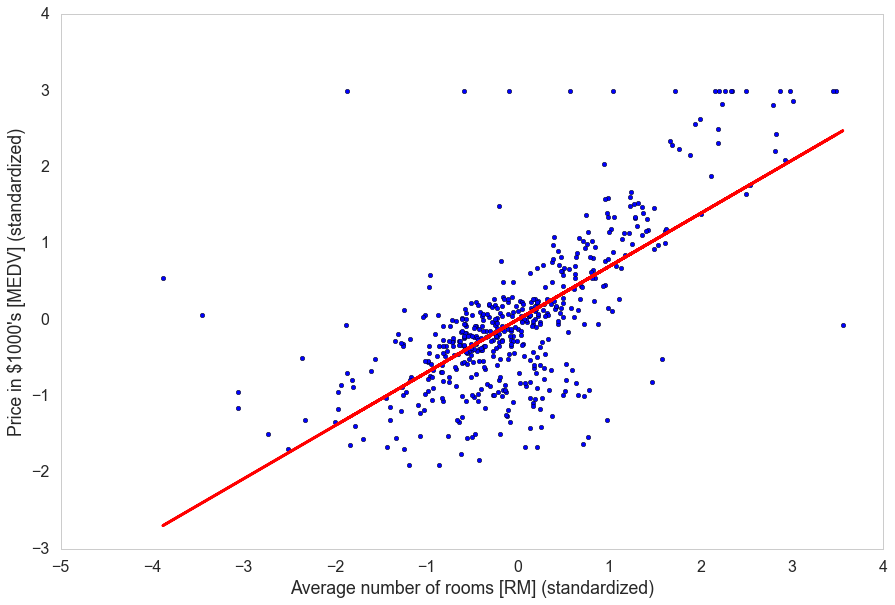

In [68]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
plt.show()

It seems like the price is clipped at y=3. It maybe also important to report the predicted outcome on their original scale.

In [69]:
num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


In [70]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


## Regression coefficient in sklearn
sklearn's `LinearRegression` uses **LIBLINEAR** library which works better with <span class="mark">unstandardized varaibles.</span>

In [71]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


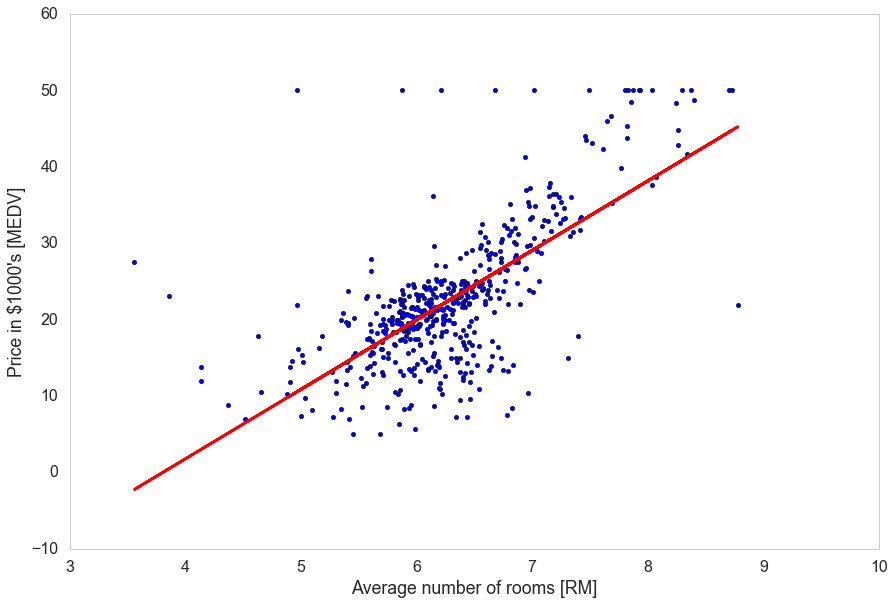

In [73]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
plt.show()

# RANSAC: a robust regression model
**RANdom SAmple Consensus (RANSAC)**: fitting a regression model to a **subset of the data**, so-called **inliers**

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b7/RANSAC_Inliers_and_Outliers.png">Figure from Wikipedia</img>

<span class="mark">**Steps**</span>
1. Select a random number of samples (inliers) and fit the model.
2. Test all other data against the fitted model and add those points that fall within a *user-given tolerance* to the inliers.
3. Refit the model using all inliers.
4. Estimate the error of the fited model vs. the inliers.
5. Terminate the algorithm if the performance meets a certain *user-defined threshold* or if a fixed number of iterations has been reached; go back to step 1 otherwise.

RANSAC vs. SLR
>A simple least squares method for line fitting will generally produce a line with a bad fit to the inliers. The reason is that it is optimally fitted to all points, including the outliers. RANSAC, on the other hand, can produce a model which is **only computed from the inliers**, provided that the probability of choosing only inliers in the selection of data is sufficiently high. There is no guarantee for this situation, however, and there are a number of algorithm parameters which must be carefully chosen to keep the level of probability reasonably high.

Assumptions
>The noisy features will not vote consistently for any single model (**few outliers**) and there are enough features to agree on a good model (**few missing data**).

In [87]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples=50,
                        loss = 'absolute_loss', # absolute verticl distances btw the fitted line and the sample points
                        residual_threshold=5.0, # samples can be inliers if the vertical distance to the fitted line <= 5 distance unit
                        random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

By default, sklearn uses **MAD (median absolute deviation)** of the target values `y`. However, the choice of an appropriate value for the inline threshold is <span class="mark">**problem-specific**, one of the disadvantages of RANSAC</span>.

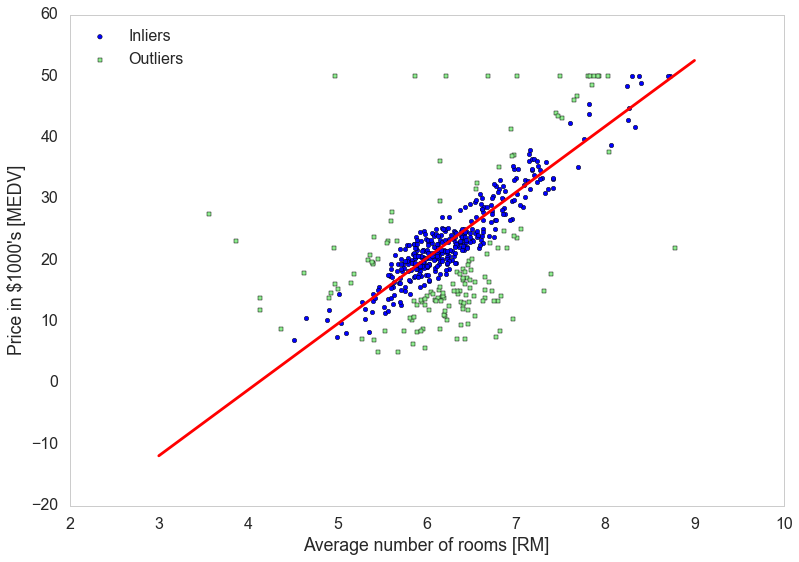

In [88]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')

plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [89]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


# Model evaluation
Similar to classificaiton, regression also requires validation (train-test split).

## Multiple regression

In [90]:
from sklearn.cross_validation import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

## Residual plots
- Residuals vs. predicted value (y)
- For multiple regression, we can't visulize the feature and target because it's now more than 2D. We can still create a residual plot to show **differences in vertical difference between the predicted and the actual.**
- Useful for detecting **outliers and nonlinearity**
- Useful to check if the errors are **randomly distributed**

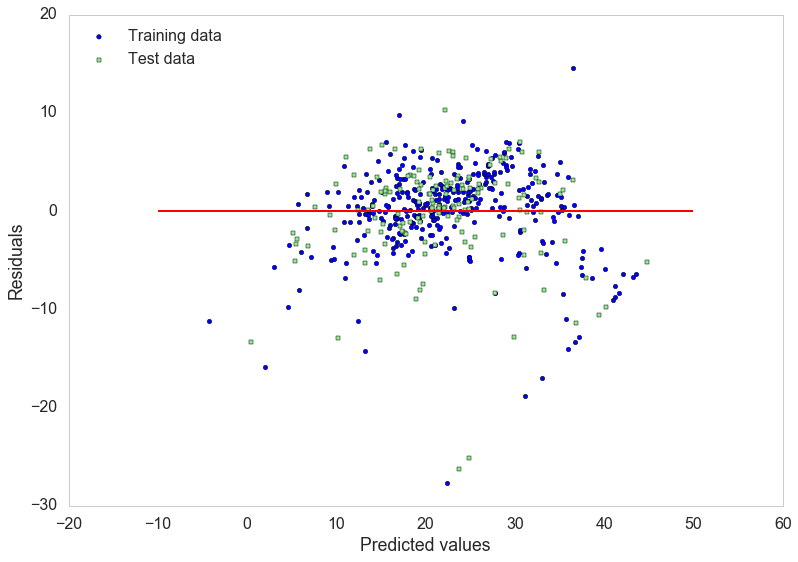

In [91]:
plt.scatter(y_train_pred, y_train_pred-y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred-y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.show()

In an ideal case, the residuals should show a random pattern. If we see a pattern in residual plots, it means <span class="mark">our model can't capture some explanatory information</span>. Outliers can be shown as the points with a larger deviation.

## Metrics
### MSE

In [94]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


Test error is slightly large, meaning that our model is overfitting.

### Coefficient of determination (R^2)

In [95]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


**[Caution](https://en.wikipedia.org/wiki/Coefficient_of_determination#Caveats)**
>In least squares regression, R2 is weakly increasing with increases in the number of regressors in the model. Because increases in the number of regressors increase the value of R2, R2 alone cannot be used as a meaningful comparison of models with very different numbers of independent variables. Adjusted R square can be used.

# Regularized linear regression
<span class="mark">Ridge regression, LASSO (least absolute shrinkage and selection operator) regression, and Elastic Net.</span>

**Ridge**
- L2 penalty

**LASSO**
- L1 penalty
- limitations: <span class="mark">selects at most n variables if m (n_features) > n (n_data).</span>

<span class="mark">**Elastic Net**</span>
- Compromise between L1 and L2; has both L1 and L2 penalty
- L1 to generate sparsity
- L2 to overcome some limitations of LASSO (such as the number of variables)

In [96]:
# ridge
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

# LASSO
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

# Elastic Net
from sklearn.linear_model import ElasticNet
lasso = ElasticNet(alpha=1.0, l1_ratio=0.5) # if l1_ratio = 1, ElasticNet is equal to Lasso.

# Polynomial regression: linear to nonlinear
Steps
1. Add a second degree polynomial term.
2. Fit a simple linear regression model for comparison
3. Fit a multiple linear on transformed features for polynomial regression

In [97]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

In [102]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [103]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

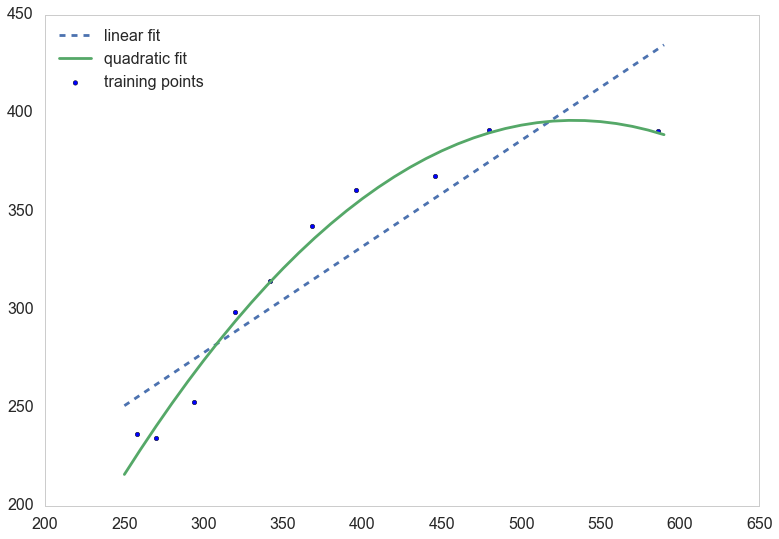

In [107]:
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', ls='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

In [108]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (mean_squared_error(y, y_lin_pred), mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (r2_score(y, y_lin_pred), r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the Housing Data
Modeling the relationship between house prices and LSTAT using second degree and third degree polynomials and compare.

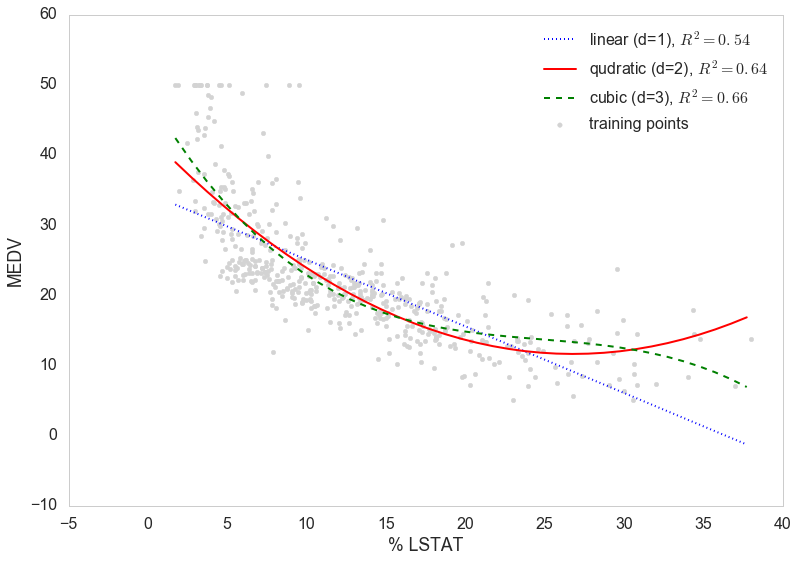

In [112]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

# create polynomial features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# linear fit
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

# quadratic fit
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

# cubic fit
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# plot results
plt.scatter(X, y, label='training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='linear (d=1), $R^2=%.2f$' % linear_r2, color='blue', lw=2, ls=':')
plt.plot(X_fit, y_quad_fit, label='qudratic (d=2), $R^2=%.2f$' % quadratic_r2, color='red', lw=2, ls='-')
plt.plot(X_fit, y_cubic_fit, label='cubic (d=3), $R^2=%.2f$' % cubic_r2, color='green', lw=2, ls='--')      
plt.xlabel('% LSTAT')
plt.ylabel('MEDV')
plt.legend(loc='upper right')
plt.show()

Although cubic trnasofrmation provides the best fit, be aware that polynomial transformation increases model complexity, which increase the danger of overfitting. <span class="mark">Thus, you need to evaluate the performance of the model on a separate test dataset to estimate the generalization performance.</span>

Differnt transformations (like log) can be used as well.

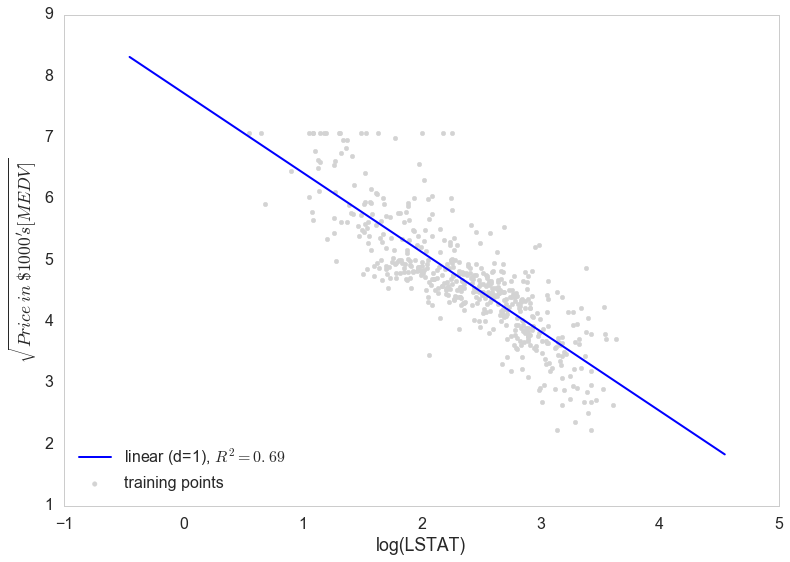

In [114]:
X_log = np.log(X)
y_sqrt = np.sqrt(y)

X_fit = np.arange(X_log.min()-1,X_log.max()+1,1)[:,np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='linear (d=1), $R^2=%.2f$' % linear_r2, color='blue', lw=2)
plt.xlabel('log(LSTAT)')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')
plt.show()

## Tree-based regression
- Sum of **piecewise** linear functions (in contrast to the *global* linear and polynomial regression models)
- **Subdividing** the input space into smaller regions that become more manageable.

### Decision tree regression
- Advantage: <span class="mark">no need for feature transformation</span>
- Regression vs. classification: replae entropy by the MSE (different cost function)

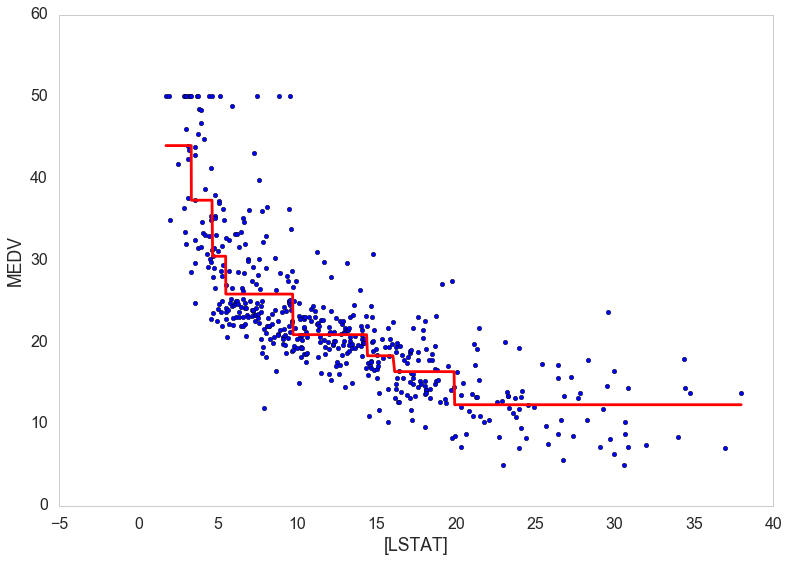

In [121]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort() 
# flatten() vs. ravel()
# The difference is that flatten always returns a copy and ravel returns a view of the original array whenever possible. 
# This isn't visible in the printed output, but if you modify the array returned by ravel, it may modify the entries in the original array.

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('[LSTAT]')
plt.ylabel('MEDV')
plt.show()

### Random forest regression
Advantages
- better generalization
- less sensitive to outliers
- don't require much parameter tuning
- again, MSE criterion

In [123]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


Quite a bit of **overfitting** (test error is much lower). 

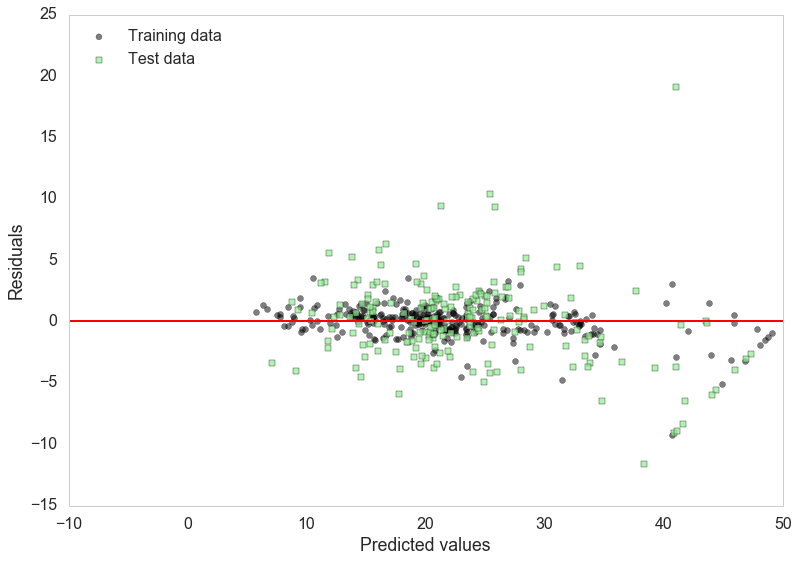

In [124]:
plt.scatter(y_train_pred, y_train_pred-y_train, c='black', marker='o', s=35, alpha=0.5, label='Training data')
plt.scatter(y_test_pred, y_test_pred-y_test, c='lightgreen', marker='s', s=35, alpha=0.7, label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()